In [36]:
import pandas as pd
import numpy as np
import requests
import re

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [37]:
df = pd.read_csv('/dlabdata1/lugeon/websites_alexa_mostpop2.gz', index_col=0)

In [38]:
df

,url,cat0,subcat0
0,http://www.nhentai.net,Adult,Arts
1,http://www.furaffinity.net,Adult,Arts
2,http://www.literotica.com,Adult,Arts
3,http://www.iafd.com,Adult,Arts
4,http://www.sofurry.com,Adult,Arts
...,...,...,...
20056,http://www.nays.org,Sports,Youth_and_High_School
20057,http://www.nhsca.com,Sports,Youth_and_High_School
20058,http://www.naysi.com,Sports,Youth_and_High_School
20059,http://www.chap.com,Sports,Youth_and_High_School


## Using XLM

In [39]:
model_st = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
tokenizer_st = model_st.tokenizer

In [40]:
def clean_url(url):
    url = re.sub(r"www.|http://|https://|-|_", '', url)
    return url.split('.')[0]

In [41]:
df['clean_url'] = df.apply(lambda row: clean_url(row.url), axis=1)

In [42]:
df['url_tokenize'] = df.apply(lambda row: tokenizer_st.tokenize(row.clean_url), axis=1)

In [43]:
df

,url,cat0,subcat0,clean_url,url_tokenize
0,http://www.nhentai.net,Adult,Arts,nhentai,"[▁nh, en, tai]"
1,http://www.furaffinity.net,Adult,Arts,furaffinity,"[▁fura, ffin, ity]"
2,http://www.literotica.com,Adult,Arts,literotica,"[▁liter, o, tica]"
3,http://www.iafd.com,Adult,Arts,iafd,"[▁i, af, d]"
4,http://www.sofurry.com,Adult,Arts,sofurry,"[▁so, fur, ry]"
...,...,...,...,...,...
20056,http://www.nays.org,Sports,Youth_and_High_School,nays,"[▁nay, s]"
20057,http://www.nhsca.com,Sports,Youth_and_High_School,nhsca,"[▁nh, sca]"
20058,http://www.naysi.com,Sports,Youth_and_High_School,naysi,"[▁nay, si]"
20059,http://www.chap.com,Sports,Youth_and_High_School,chap,[▁chap]


In [44]:
df.cat0.value_counts()

Sports            2969
Business          2221
Computers         1863
Shopping          1664
Arts              1531
Society           1480
Recreation        1445
Health            1407
Science           1130
Games              805
Reference          712
News               703
Home               596
Kids_and_Teens     567
Regional           500
Adult              468
Name: cat0, dtype: int64

In [45]:
df = df.groupby('cat0').sample(468, random_state=42)
df.shape

(7488, 5)

In [46]:
df.reset_index(inplace=True)

In [238]:
df['url_emb_st'] = df.apply(lambda row: model_st.encode(row.clean_url), axis=1)

KeyboardInterrupt: 

In [239]:
x = np.concatenate(df.url_emb_st.to_numpy()).ravel()
x = x.reshape(-1, 768)
x.shape

AttributeError: 'DataFrame' object has no attribute 'url_emb_st'

In [46]:
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x)

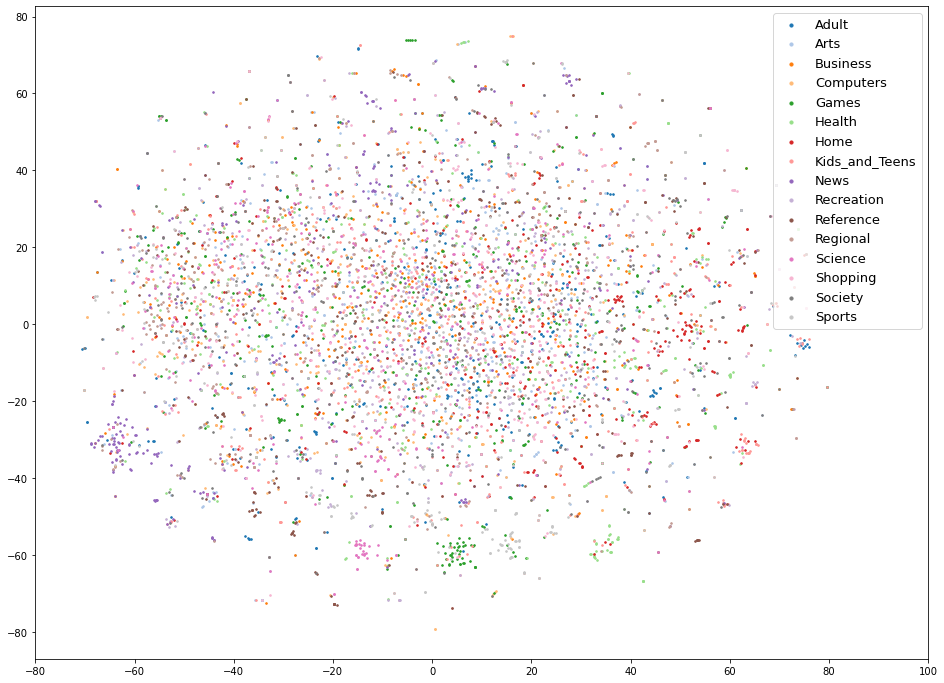

In [49]:
categories = df.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 10
marker = '.'

fig, ax = plt.subplots(figsize=(16, 12))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df[df.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-80,100])
#ax.set_ylim([0,1])

#ax.set_xticks([], [])
#ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=2, fontsize=13)
plt.plot();

## Using ngrams

In [47]:
def compute_ngram(s, n):
    return [s[i:i+n] for i in range(0, len(s)-n+1)]

def concat_ngrams(s, ns):
    l = []
    for n in ns:
        l += compute_ngram(s, n)
    return list(set(l))

In [48]:
ns = range(3, 7)

df['ngrams'] = df.apply(lambda row: concat_ngrams(row.clean_url, ns), axis=1)

In [49]:
df_ngrams = df[['cat0', 'ngrams']].groupby('cat0').agg(lambda col: [s for l in col for s in l])

In [50]:
def top_ngrams(l):
    return pd.Series(l).value_counts().to_dict()

In [51]:
df_ngrams['top_ngrams_count'] = df_ngrams.apply(lambda row: top_ngrams(row.ngrams), axis=1)

In [52]:
df_ngrams

,ngrams,top_ngrams_count
cat0,,
Adult,"[scl, tus, tusc, uscl, usc, tuscl, redzo, redz...","{'ult': 22, 'dul': 21, 'dult': 21, 'adul': 21,..."
Arts,"[lass, class, clas, assr, stud, udio, sroom, s...","{'art': 50, 'ing': 23, 'ine': 21, 'the': 20, '..."
Business,"[iun, iviu, viu, viv, viviun, iviun, viviu, iv...","{'ter': 19, 'tra': 17, 'ing': 17, 'ine': 16, '..."
Computers,"[alt, tbi, altbi, bina, ari, binar, binari, na...","{'ter': 18, 'com': 16, 'ion': 14, 'tec': 14, '..."
Games,"[kad, kkada, kadakk, adak, adakk, kada, akka, ...","{'ame': 69, 'gam': 68, 'game': 64, 'mes': 41, ..."
Health,"[edaids, peda, edaid, ped, aid, eda, daids, id...","{'hea': 30, 'alt': 29, 'eal': 28, 'alth': 27, ..."
Home,"[rdchi, ard, ackyar, dchick, bac, kya, rdch, h...","{'ing': 59, 'ome': 29, 'the': 29, 'hom': 25, '..."
Kids_and_Teens,"[inonl, onl, nline, olinon, inon, line, nonl, ...","{'kid': 29, 'kids': 24, 'ids': 24, 'the': 23, ..."
News,"[ave, aveho, heav, heaveh, heave, eave, eaveh,...","{'new': 87, 'ews': 84, 'news': 84, 'the': 49, ..."


In [68]:
def reduce_ngrams(ngrams_dict, nb_rep_ngrams):
    red = set()
    for s in ngrams_dict.keys(): # candidate
        valid = True
        init_count = ngrams_dict[s]
        for t in list(ngrams_dict.keys()): # superstring
            if len(t) > len(s): # longest substring
                if s in t: # if there is a super-string in the ngrams
                    if (init_count - ngrams_dict[t])/init_count <= 0.1: # and that there count rapport is less than 0.6
                        s = t # discard substring
        if valid:
            red.add(s)
        if len(red) == nb_rep_ngrams:
            break
                
    return red

In [69]:
nb_rep_ngrams = 50

df_ngrams['rep_ngrams'] = df_ngrams.apply(lambda row: reduce_ngrams(row.top_ngrams_count, nb_rep_ngrams), axis=1)

In [70]:
all_rep_grams = np.unique([gram for gramlist in df_ngrams.rep_ngrams for gram in gramlist])
all_rep_grams.shape

(412,)

In [71]:
all_rep_grams

array(['ack', 'ade', 'adult', 'age', 'ahjong', 'ail', 'ain', 'ala', 'ale',
       'ali', 'alis', 'all', 'alt', 'ama', 'ame', 'ames', 'amp', 'ana',
       'anc', 'ance', 'and', 'ani', 'ant', 'anta', 'antarc', 'arc',
       'arch', 'archi', 'archiv', 'arctic', 'ard', 'are', 'ari', 'ars',
       'art', 'arti', 'arts', 'ary', 'assics', 'ast', 'ate', 'ath',
       'athe', 'ati', 'ation', 'att', 'baby', 'bad', 'badmin', 'ball',
       'ban', 'bank', 'bio', 'bird', 'ble', 'boa', 'book', 'bri',
       'bridge', 'cal', 'can', 'car', 'care', 'ces', 'cha', 'che', 'chem',
       'chess', 'chi', 'chives', 'cience', 'cienti', 'cigar', 'cke',
       'class', 'classi', 'cloped', 'club', 'col', 'color', 'colori',
       'com', 'comi', 'comp', 'comput', 'con', 'cos', 'cost', 'cro',
       'cti', 'ctor', 'cyclop', 'daily', 'dar', 'den', 'dent', 'der',
       'dia', 'dic', 'dict', 'doc', 'ear', 'eat', 'eather', 'ech', 'eco',
       'ect', 'edi', 'een', 'ega', 'ele', 'eli', 'ell', 'ema', 'ence',
       'en

In [72]:
def encode_repgrams_onehot(s):
    onehot = np.array([int(gram in s) for gram in all_rep_grams])
    return onehot

In [73]:
df['repgrams_oh'] = df.apply(lambda row: encode_repgrams_onehot(row.clean_url), axis=1)

In [74]:
x = np.concatenate(df.repgrams_oh.to_numpy()).ravel()
x = x.reshape(-1, all_rep_grams.shape[0])
x.shape

(7488, 412)

In [75]:
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x)

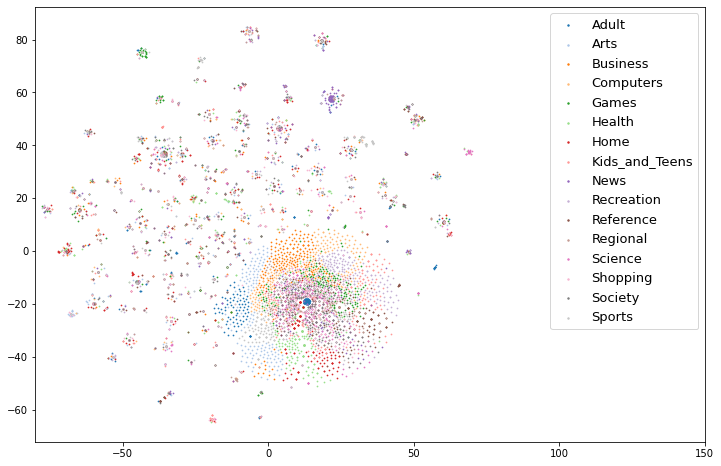

In [64]:
categories = df.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 2
marker = '.'

fig, ax = plt.subplots(figsize=(12, 8))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df[df.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-80,150])
#ax.set_ylim([0,1])

#ax.set_xticks([], [])
#ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=2, fontsize=13)
plt.plot();

In [194]:
repgrams_vec = {}
for r in tqdm(all_rep_grams):
    repgrams_vec[r] = model_st.encode(r)

100%|██████████| 145/145 [00:04<00:00, 32.89it/s]


In [223]:
def encode_repgrams_vec(s):
    acc = np.zeros(768)
    i = 0
    for gram in [g for g in all_rep_grams if g in s]:
        acc += repgrams_vec[gram]
        i += 1
    if i == 0:
        return acc
    else:
        return acc / i

In [224]:
df['repgrams_vec'] = df.apply(lambda row: encode_repgrams_vec(row.clean_url), axis=1)

In [227]:
x = np.concatenate(df.repgrams_vec.to_numpy()).ravel()
x = x.reshape(-1, 768)
print(x.shape)
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x)

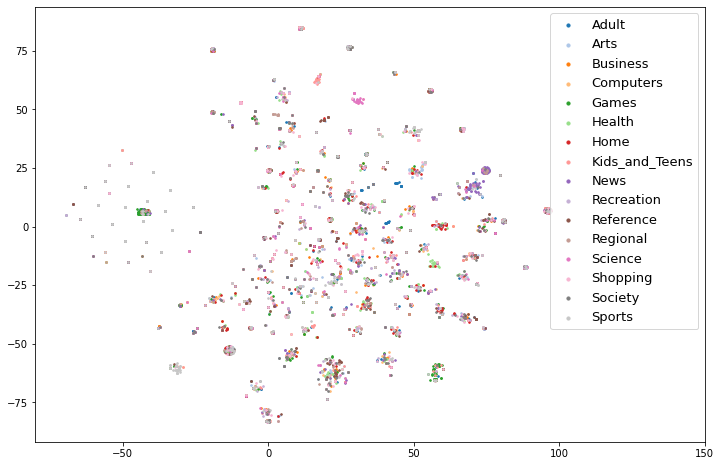

In [228]:
categories = df.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 10
marker = '.'

fig, ax = plt.subplots(figsize=(12, 8))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df[df.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-80,150])
#ax.set_ylim([0,1])

#ax.set_xticks([], [])
#ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=2, fontsize=13)
plt.plot();

## Classifier on one hot

In [77]:
df.shape

(7488, 8)

In [45]:
from sklearn import svm
from sklearn.model_selection import cross_validate

In [46]:
def categorize(c):
    return categories.tolist().index(c)

In [78]:
df['catno'] = df.apply(lambda row: categorize(row.cat0), axis=1)

In [79]:
y = df.catno.values

### SVM

In [306]:
clf = svm.SVC(kernel='linear', C=1)
scores = cross_validate(clf, x, y, cv=5, scoring='accuracy', return_train_score=True, verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [307]:
scores

{'fit_time': array([11.97078776, 11.94847202, 11.7994349 , 11.64180422, 11.47340369]),
 'score_time': array([1.97466183, 1.90649676, 1.6076889 , 1.54023194, 1.53174305]),
 'test_score': array([0.17823765, 0.20627503, 0.18491322, 0.1750167 , 0.20240481]),
 'train_score': array([0.23522538, 0.22854758, 0.23539232, 0.24119513, 0.23451844])}

In [308]:
scores['test_score'].mean()

0.18936948217752816

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
from tqdm import tqdm

### Random forest with all vectors

In [399]:
maxd = 70

train = []
test = []

for d in tqdm(range(1, maxd+1)):
    forest = RandomForestClassifier(n_estimators=300, max_depth=d, random_state=42)
    forest_scores = cross_validate(forest, x, y, cv=5, scoring='accuracy', return_train_score=True)
    train += [forest_scores['train_score'].mean()]
    test += [forest_scores['test_score'].mean()]

100%|██████████| 70/70 [23:24<00:00, 20.07s/it]


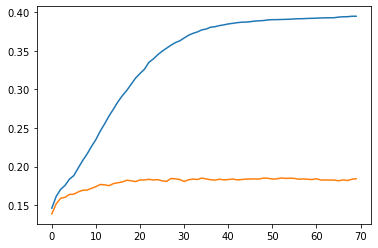

In [401]:
plt.plot(train)
plt.plot(test)
plt.show()

In [54]:
best_d = 35

forest = RandomForestClassifier(n_estimators=300, max_depth=best_d, random_state=42)
forest_scores = cross_validate(forest, x, y, cv=5, scoring=['accuracy', 'precision_macro'], return_train_score=True)

In [55]:
forest_scores

{'fit_time': array([3.94491172, 3.34348178, 3.42921185, 3.32619476, 3.21178007]),
 'score_time': array([0.15565753, 0.13467526, 0.13728166, 0.13107109, 0.13418508]),
 'test_accuracy': array([0.18958611, 0.20093458, 0.17690254, 0.18704075, 0.20641283]),
 'train_accuracy': array([0.40517529, 0.41135225, 0.41252087, 0.41562344, 0.40727758]),
 'test_precision_macro': array([0.28474785, 0.32438013, 0.27887466, 0.28319518, 0.30179173]),
 'train_precision_macro': array([0.67492859, 0.6650341 , 0.66096496, 0.65463835, 0.6398133 ])}

### with only non-null vectors

In [316]:
no_repgram = (df.repgrams_oh.apply(sum) == 0).value_counts()
(no_repgram[True] / (no_repgram[True] + no_repgram[False]))

0.7952724358974359

percentage of url with that does not contain any representative n-grams

In [317]:
x = np.concatenate(df[df.repgrams_oh.apply(sum) != 0].repgrams_oh.to_numpy()).ravel()
x = x.reshape(-1, all_rep_grams.shape[0])
x.shape

(1533, 12)

In [318]:
y = df[df.repgrams_oh.apply(sum) != 0].catno.values

In [319]:
shuffle_ix = np.arange(x.shape[0])
np.random.shuffle(shuffle_ix)
x = x[shuffle_ix]
y = y[shuffle_ix]

In [303]:
maxd = 60

train = []
test = []

for d in tqdm(range(1, maxd+1)):
    forest = RandomForestClassifier(n_estimators=300, max_depth=d, random_state=42)
    forest_scores = cross_validate(forest, x, y, cv=5, scoring='accuracy', return_train_score=True)
    train += [forest_scores['train_score'].mean()]
    test += [forest_scores['test_score'].mean()]

  0%|          | 0/60 [00:02<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-303-2572d3bb9e30>", line 8, in <module>
    forest_scores = cross_validate(forest, x, y, cv=5, scoring='accuracy', return_train_score=True)
  File "/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 242, in cross_validate
    scores = parallel(
  File "/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/joblib/parallel.py", line 1051, in __call__
    while self.dispatch_one_batch(iterator):
  File "/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "/dlabdata1/lugeon/lugeon

TypeError: object of type 'NoneType' has no len()

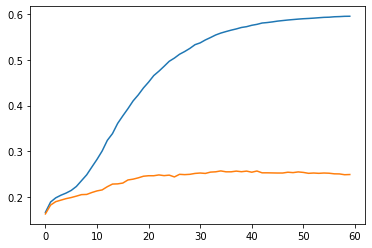

In [394]:
plt.plot(train)
plt.plot(test)
plt.show()

In [320]:
forest = RandomForestClassifier(n_estimators=300, max_depth=3, random_state=42)
forest_scores = cross_validate(forest, x, y, cv=5, scoring=['accuracy', 'precision_weighted'], return_train_score=True, error_score=0)

/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/dlabdata1/lugeon/lugeon-env/lib/python3.8/site-pack

In [26]:
forest_scores

NameError: name 'forest_scores' is not defined